In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 13.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

START_DATE = "2017-01-01"
DUE_DATE = "2022-03-30"

In [9]:
def get_bitcoin_candlestick(start_date, end_date):
    """  get bitcoin daily info from yahooFinance and remove non values"""

    btc_df = yf.download("BTC-USD", start_date, end_date,
                         auto_adjust=True)

    btc_df['daily_return'] = (btc_df['Close'] -btc_df['Open']) / btc_df['Open']

    btc_df = btc_df.dropna()

    return btc_df


btc_df = get_bitcoin_candlestick(start_date=START_DATE , end_date=DUE_DATE)
btc_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.035974
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023165
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021770
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.105640
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.123927


In [10]:
# btc_df.Date = pd.to_datetime(btc_df.date , dayfirst = True)
# btc_df.set_index("Date", inplace=True)
btc_df= btc_df.asfreq('b')
btc_df = btc_df.fillna(method = 'ffill')

# QQ Plot

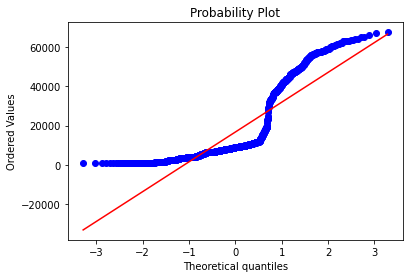

In [13]:
import scipy.stats
import pylab

scipy.stats.probplot(btc_df.Close , plot=pylab)
pylab.show()

# **compare time series with white noise**

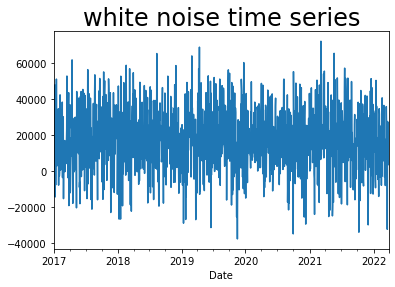

In [14]:
wn = np.random.normal(loc = btc_df.Close.mean() , scale = btc_df.Close.std() , size = len(btc_df))
btc_df['wn'] = wn
btc_df.wn.plot()
plt.title("white noise time series" ,size = 24)
plt.show()

                  price
date                   
1994-01-07  1122.139662
1994-01-10  1080.347860
1994-01-11  1082.095245
1994-01-12  1083.639265
1994-01-13  1067.146255


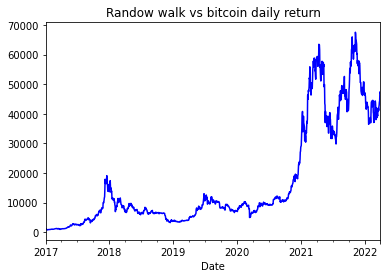

In [24]:
rw = pd.read_csv("025 RandWalk.csv")
rw.date = pd.to_datetime(rw.date , dayfirst = True)
rw.set_index("date", inplace = True)
rw = rw.asfreq('b')

btc_df['rw'] = rw.price
print(rw.head())
btc_df.rw.plot(color = 'red')
btc_df.Close.plot(color = 'blue')
plt.title("Randow walk vs bitcoin daily return")
plt.show()


## dickey-fuller test for stationary

In [25]:
import statsmodels.tsa.stattools as sts

sts.adfuller(btc_df.Close)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-0.7604667682058226,
 0.8304598118682299,
 8,
 1359,
 {'1%': -3.435170967430817,
  '10%': -2.5679035297726274,
  '5%': -2.8636690928667523},
 22618.635181543814)

# Seasonality

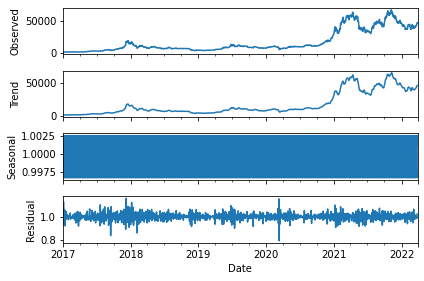

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

s_dec_additive = seasonal_decompose(btc_df.Close , model="multiplicative")
s_dec_additive.plot()
plt.show()

# time dependency analysis -> autocorrelation with ACF 

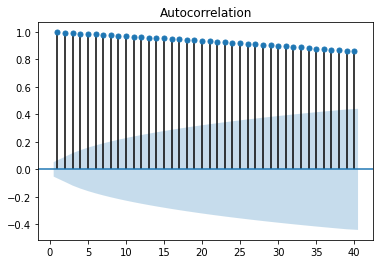

In [27]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(btc_df.Close , lags = 40 , zero = False)
plt.show()

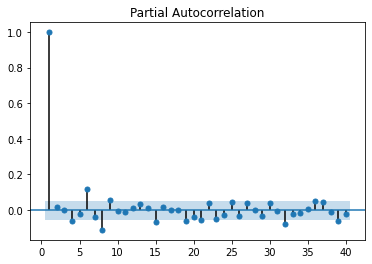

In [28]:
#direct relatin between past lags and noe

sgt.plot_pacf(btc_df.Close , lags =40 , zero = False , method = ('ols'))
plt.show()

# Returns

In [30]:
btc_df['returns'] = btc_df.Close.pct_change(1)*100

In [31]:
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(btc_df.Close , order =(1,1,1))
result_arima = model_arima.fit()
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1367
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11513.200
Method:                       css-mle   S.D. of innovations           1100.258
Date:                Mon, 30 May 2022   AIC                          23034.400
Time:                        06:17:55   BIC                          23055.281
Sample:                    01-03-2017   HQIC                         23042.215
                         - 03-30-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.6803     29.286      1.150      0.250     -23.720      91.081
ar.L1.D.Close    -0.0228      0.582     -0.039      0.969      -1.164       1.118
ma.L1.D.Close     0.0066      0.582      0.011      0.991      -1.134       1.147
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.8001           +0.0000j           43.8001            0.5000
MA.1         -151.6526           +0.0000j          151.6526            0.5000
-----------------------------------------------------------------------------
"""

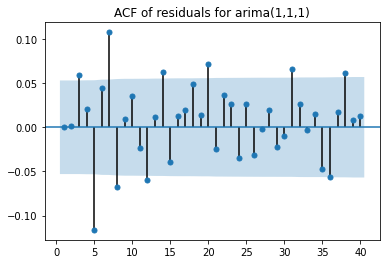

In [33]:
btc_df['res_ar_1_i_ma_1'] = result_arima.resid
sgt.plot_acf(btc_df.res_ar_1_i_ma_1[1:] , zero=False, lags =40)
plt.title("ACF of residuals for arima(1,1,1)")
plt.show()

In [39]:
model_arima_1_1_7 = ARIMA(btc_df.Close , order =(1,1,7))
result_arima_1_1_7 = model_arima_1_1_7.fit(start_ar_lags = 7)
result_arima_1_1_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1367
Model:                 ARIMA(1, 1, 7)   Log Likelihood              -11492.994
Method:                       css-mle   S.D. of innovations           1084.054
Date:                Mon, 30 May 2022   AIC                          23005.987
Time:                        06:35:47   BIC                          23058.191
Sample:                    01-03-2017   HQIC                         23025.526
                         - 03-30-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.6844     31.821      1.059      0.290     -28.684      96.053
ar.L1.D.Close    -0.4591      0.147     -3.129      0.002      -0.747      -0.172
ma.L1.D.Close     0.4527      0.146      3.103      0.002       0.167       0.739
ma.L2.D.Close     0.0171      0.030      0.576      0.565      -0.041       0.075
ma.L3.D.Close     0.0487      0.030      1.634      0.103      -0.010       0.107
ma.L4.D.Close     0.0404      0.031      1.313      0.190      -0.020       0.101
ma.L5.D.Close    -0.0898      0.029     -3.144      0.002      -0.146      -0.034
ma.L6.D.Close     0.0012      0.035      0.035      0.972      -0.068       0.070
ma.L7.D.Close     0.1138      0.027      4.227      0.000       0.061       0.167
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1779           +0.0000j            2.1779            0.5000
MA.1           -1.3247           -0.0000j            1.3247           -0.5000
MA.2           -0.9495           -0.8560j            1.2784           -0.3832
MA.3           -0.9495           +0.8560j            1.2784            0.3832
MA.4            0.2495           -1.3061j            1.3297           -0.2200
MA.5            0.2495           +1.3061j            1.3297            0.2200
MA.6            1.3569           -0.6744j            1.5153           -0.0734
MA.7            1.3569           +0.6744j            1.5153            0.0734
-----------------------------------------------------------------------------
"""

In [36]:

model_arima_1_1_5 = ARIMA(btc_df.Close , order =(1,1,5))
result_arima_1_1_5 = model_arima_1_1_5.fit(start_ar_lags = 7)
result_arima_1_1_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1367
Model:                 ARIMA(1, 1, 5)   Log Likelihood              -11501.732
Method:                       css-mle   S.D. of innovations           1091.036
Date:                Mon, 30 May 2022   AIC                          23019.465
Time:                        06:33:29   BIC                          23061.228
Sample:                    01-03-2017   HQIC                         23035.095
                         - 03-30-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.6802     28.793      1.170      0.242     -22.754      90.114
ar.L1.D.Close    -0.1314      0.137     -0.956      0.339      -0.401       0.138
ma.L1.D.Close     0.1204      0.135      0.891      0.373      -0.144       0.385
ma.L2.D.Close     0.0287      0.027      1.049      0.294      -0.025       0.082
ma.L3.D.Close     0.0437      0.027      1.590      0.112      -0.010       0.098
ma.L4.D.Close     0.0231      0.029      0.791      0.429      -0.034       0.080
ma.L5.D.Close    -0.1121      0.027     -4.179      0.000      -0.165      -0.060
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.6092           +0.0000j            7.6092            0.5000
MA.1           -1.2298           -0.8458j            1.4926           -0.4041
MA.2           -1.2298           +0.8458j            1.4926            0.4041
MA.3            0.4690           -1.4483j            1.5224           -0.2002
MA.4            0.4690           +1.4483j            1.5224            0.2002
MA.5            1.7274           -0.0000j            1.7274           -0.0000
-----------------------------------------------------------------------------
"""

In [41]:
from scipy.stats import chi2

def LLR_test(mod_1 , mod_2 , DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2 - L1))
    p = chi2.sf(LR , DF).round(3)
    return p


    